In [1]:
import os
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import xgboost as xgb
import kagglehub


In [2]:
path = kagglehub.dataset_download("ryanluong1/valorant-champion-tour-2021-2023-data")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Vedant Hirekar\.cache\kagglehub\datasets\ryanluong1\valorant-champion-tour-2021-2023-data\versions\40


In [3]:
for root, dirs, files in os.walk(path):
    for file in files:
        print(os.path.join(root, file))

C:\Users\Vedant Hirekar\.cache\kagglehub\datasets\ryanluong1\valorant-champion-tour-2021-2023-data\versions\40\all_ids\all_matches_games_ids.csv
C:\Users\Vedant Hirekar\.cache\kagglehub\datasets\ryanluong1\valorant-champion-tour-2021-2023-data\versions\40\all_ids\all_players_ids.csv
C:\Users\Vedant Hirekar\.cache\kagglehub\datasets\ryanluong1\valorant-champion-tour-2021-2023-data\versions\40\all_ids\all_teams_ids.csv
C:\Users\Vedant Hirekar\.cache\kagglehub\datasets\ryanluong1\valorant-champion-tour-2021-2023-data\versions\40\all_ids\all_teams_mapping.csv
C:\Users\Vedant Hirekar\.cache\kagglehub\datasets\ryanluong1\valorant-champion-tour-2021-2023-data\versions\40\all_ids\all_tournaments_stages_match_types_ids.csv
C:\Users\Vedant Hirekar\.cache\kagglehub\datasets\ryanluong1\valorant-champion-tour-2021-2023-data\versions\40\vct_2021\agents\agents_pick_rates.csv
C:\Users\Vedant Hirekar\.cache\kagglehub\datasets\ryanluong1\valorant-champion-tour-2021-2023-data\versions\40\vct_2021\agents\

In [4]:
data = pd.read_csv(os.path.join(path, 'vct_2024', 'agents', 'teams_picked_agents.csv'))
data.head()

,Tournament,Stage,Match Type,Map,Team,Agent,Total Wins By Map,Total Loss By Map,Total Maps Played
0,Valorant Champions 2024,Playoffs,Upper Quarterfinals,Sunset,DRX,sova,0,1,1
1,Valorant Champions 2024,Playoffs,Upper Quarterfinals,Sunset,DRX,cypher,0,1,1
2,Valorant Champions 2024,Playoffs,Upper Quarterfinals,Sunset,DRX,omen,0,1,1
3,Valorant Champions 2024,Playoffs,Upper Quarterfinals,Sunset,DRX,breach,0,1,1
4,Valorant Champions 2024,Playoffs,Upper Quarterfinals,Sunset,DRX,neon,0,1,1


In [5]:
data['Win Rate'] = data['Total Wins By Map'] / data['Total Maps Played']
data['Win Rate'] = data['Win Rate'].fillna(0)
data['Win'] = (data['Total Wins By Map'] > data['Total Loss By Map']).astype(int)

In [6]:
data = (
    data.groupby(['Tournament', 'Stage', 'Match Type', 'Map', 'Team'])
    .agg({
        'Agent': lambda x: ', '.join(sorted(x)),
        'Win': 'max'
    })
    .reset_index()
)
data.rename(columns={'Agent': 'Agents Played', 'Win': 'Match Outcome'}, inplace=True)
data.head()

,Tournament,Stage,Match Type,Map,Team,Agents Played,Match Outcome
0,Champions Tour 2024: Americas Kickoff,All Stages,All Match Types,Ascent,Cloud9,"jett, kayo, killjoy, omen, sova",0
1,Champions Tour 2024: Americas Kickoff,All Stages,All Match Types,Ascent,Evil Geniuses,"cypher, jett, kayo, omen, sova",1
2,Champions Tour 2024: Americas Kickoff,All Stages,All Match Types,Ascent,FURIA,"jett, kayo, killjoy, omen, sova",0
3,Champions Tour 2024: Americas Kickoff,All Stages,All Match Types,Ascent,G2 Esports,"cypher, jett, kayo, omen, viper",1
4,Champions Tour 2024: Americas Kickoff,All Stages,All Match Types,Ascent,KRÜ Esports,"jett, kayo, killjoy, omen, sova",0


In [7]:
data['Agents Played'] = data['Agents Played'].apply(lambda x: x.split(', '))

In [8]:
data.describe()

,Match Outcome
count,3066.000000
mean,0.470972
std,0.499238
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3066 entries, 0 to 3065
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Tournament     3066 non-null   object
 1   Stage          3066 non-null   object
 2   Match Type     3066 non-null   object
 3   Map            3066 non-null   object
 4   Team           3066 non-null   object
 5   Agents Played  3066 non-null   object
 6   Match Outcome  3066 non-null   int64 
dtypes: int64(1), object(6)
memory usage: 167.8+ KB


In [10]:
tournament_summary = data['Tournament'].value_counts()
map_summary = data['Map'].value_counts()
stage_summary = data['Stage'].value_counts()
match_type_summary = data['Match Type'].value_counts()

print("=== Descriptive Statistics Summary ===")
print("\n1. Number of Matches per Tournament:")
print(tournament_summary)

print("\n2. Number of Matches per Map:")
print(map_summary)

print("\n3. Distribution of Stages:")
print(stage_summary)

print("\n4. Distribution of Match Types:")
print(match_type_summary)

=== Descriptive Statistics Summary ===

1. Number of Matches per Tournament:
Tournament
Champions Tour 2024: EMEA Stage 1        257
Champions Tour 2024: China Stage 1       253
Valorant Champions 2024                  252
Champions Tour 2024: Pacific Stage 1     249
Champions Tour 2024: Americas Stage 1    248
Champions Tour 2024: Pacific Stage 2     239
Champions Tour 2024: Americas Stage 2    231
Champions Tour 2024: EMEA Stage 2        227
Champions Tour 2024: China Stage 2       217
Champions Tour 2024: Masters Shanghai    190
Champions Tour 2024: Americas Kickoff    149
Champions Tour 2024: China Kickoff       144
Champions Tour 2024: Pacific Kickoff     140
Champions Tour 2024: EMEA Kickoff        139
Champions Tour 2024: Masters Madrid      131
Name: count, dtype: int64

2. Number of Matches per Map:
Map
Lotus     523
Sunset    495
Icebox    457
Bind      414
Ascent    396
Split     334
Breeze    241
Haven     137
Abyss      69
Name: count, dtype: int64

3. Distribution of Stag

C:\Users\Vedant Hirekar\AppData\Local\Temp\ipykernel_14504\2687529625.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=map_summary.index, y=map_summary.values, palette = "coolwarm")


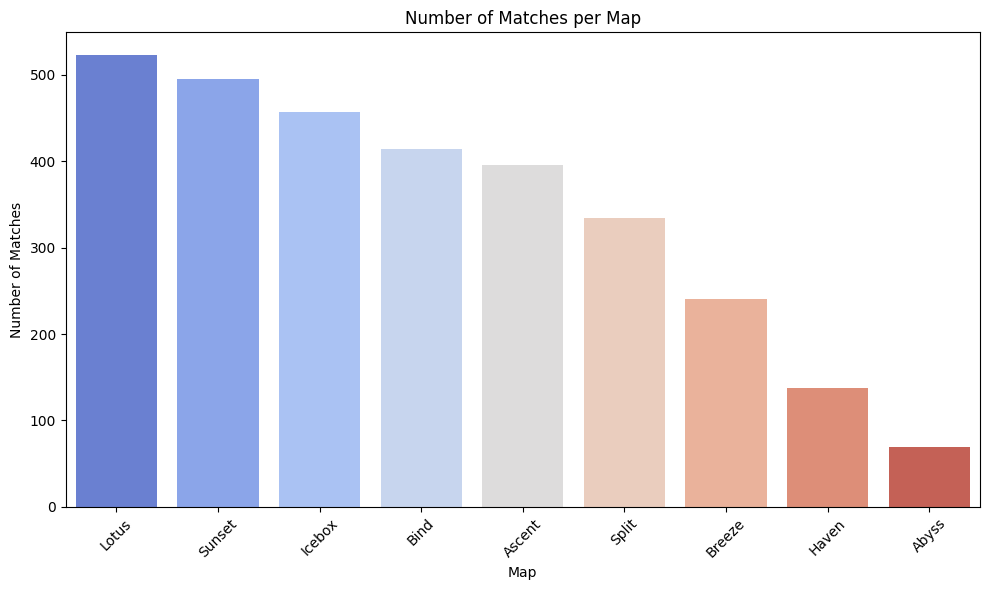

In [11]:
plt.figure(figsize=(10, 6))
sns.barplot(x=map_summary.index, y=map_summary.values, palette = "coolwarm")

plt.title("Number of Matches per Map")
plt.xlabel("Map")
plt.ylabel("Number of Matches")

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In the visualization above we can see how many matches have been played on each of the maps. The maps Abyss and Haven are relatively newer so the no. of matches played on them is less. 

C:\Users\Vedant Hirekar\AppData\Local\Temp\ipykernel_14504\276937142.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=tournament_summary.index, y=tournament_summary.values, palette="coolwarm")


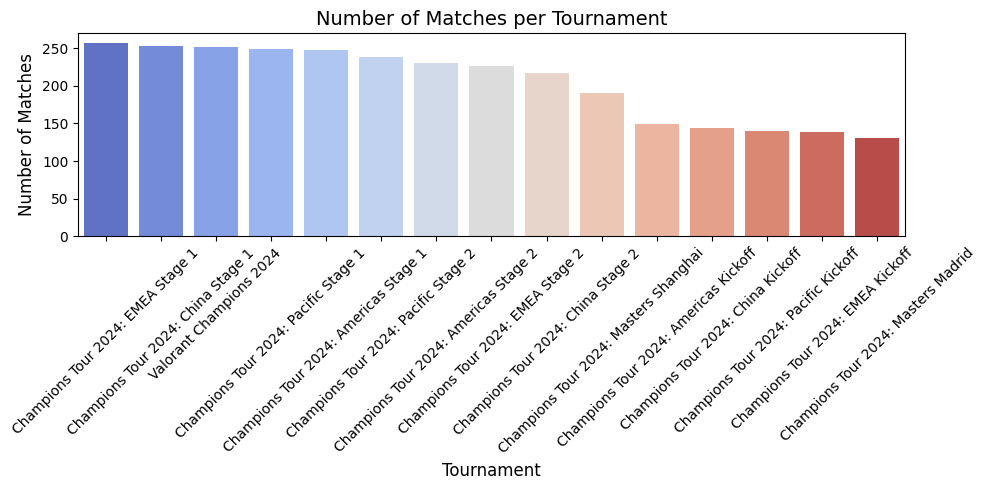

In [12]:
plt.figure(figsize=(10, 5))
sns.barplot(x=tournament_summary.index, y=tournament_summary.values, palette="coolwarm")
plt.title("Number of Matches per Tournament", fontsize=14)
plt.xlabel("Tournament", fontsize=12)
plt.ylabel("Number of Matches", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Above we can see the no. of matches played in each tournament. 

C:\Users\Vedant Hirekar\AppData\Local\Temp\ipykernel_14504\4214555352.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=agent_winrate.index, y=agent_winrate.values, palette="coolwarm")


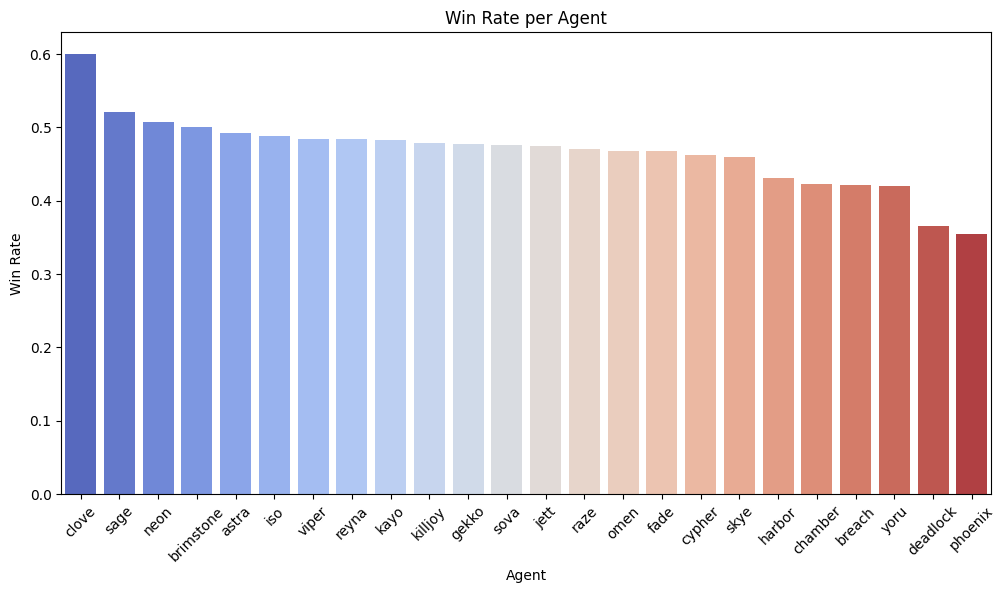

In [13]:
mlb = MultiLabelBinarizer()
agents_df = pd.DataFrame(mlb.fit_transform(data['Agents Played']), columns=mlb.classes_, index=data.index)
agent_winrate = agents_df.mul(data['Match Outcome'], axis=0).sum() / agents_df.sum()

plt.figure(figsize=(12, 6))
agent_winrate = agent_winrate.sort_values(ascending=False)
sns.barplot(x=agent_winrate.index, y=agent_winrate.values, palette="coolwarm")
plt.title("Win Rate per Agent")
plt.xlabel("Agent")
plt.ylabel("Win Rate")
plt.xticks(rotation=45)
plt.show()

Above we can see the probability of winning if a particular agent is picked. We can see phoenix having a less win rate and this actually explains why it is not usually played in Competative matches. 

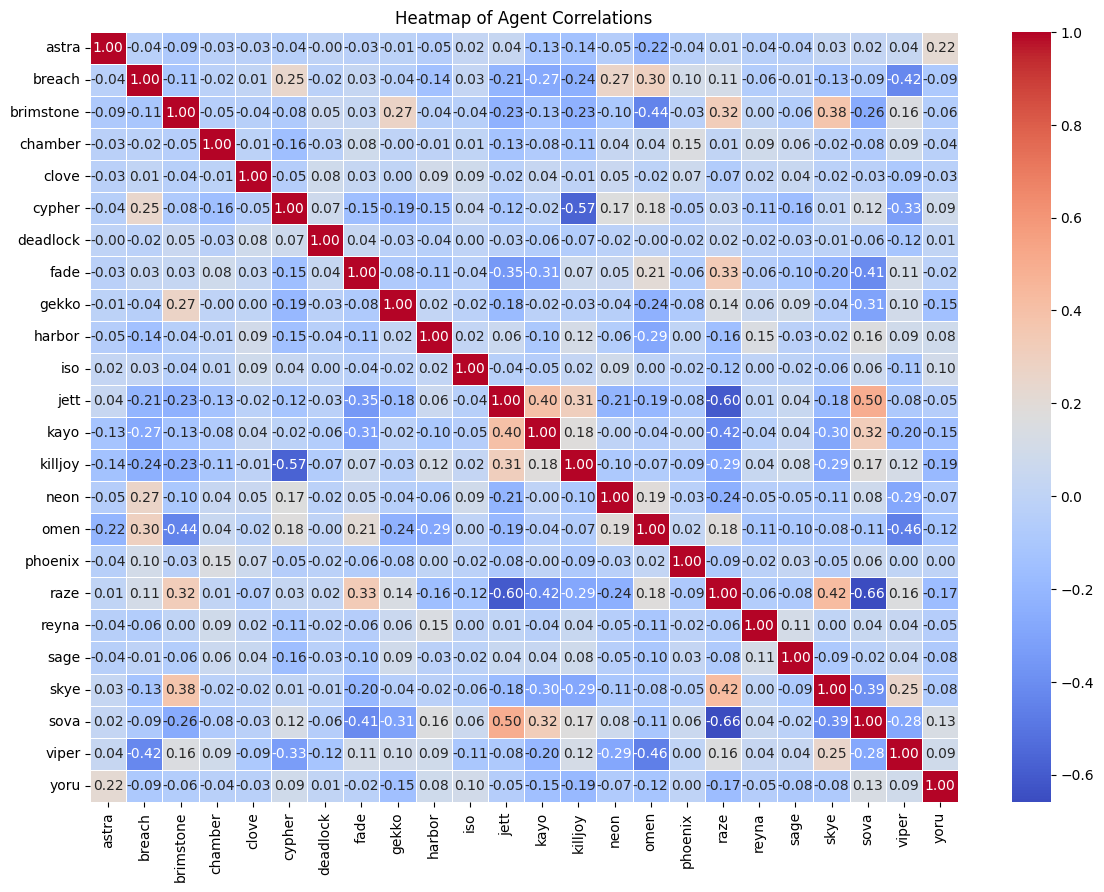

In [14]:
agent_match_data = pd.concat([agents_df, data['Match Outcome']], axis=1)
correlation_matrix = agent_match_data.corr()
agent_correlation = correlation_matrix.loc[agents_df.columns, agents_df.columns]

plt.figure(figsize=(14, 10))
sns.heatmap(agent_correlation, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Heatmap of Agent Correlations")
plt.show()

Her we can see the co-relation of agents. Usually, in a tactical game like valorant, it is very important to do combinations of multiple agents to complement eachother's abilities to form a strong defense or attack. Here we can see the stats like sova and jett or raze and skye having a good correlation and we actually see these combos being played in competative matches.

C:\Users\Vedant Hirekar\AppData\Local\Temp\ipykernel_14504\226075582.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=agent_pick_freq.index, y=agent_pick_freq.values, palette="coolwarm")


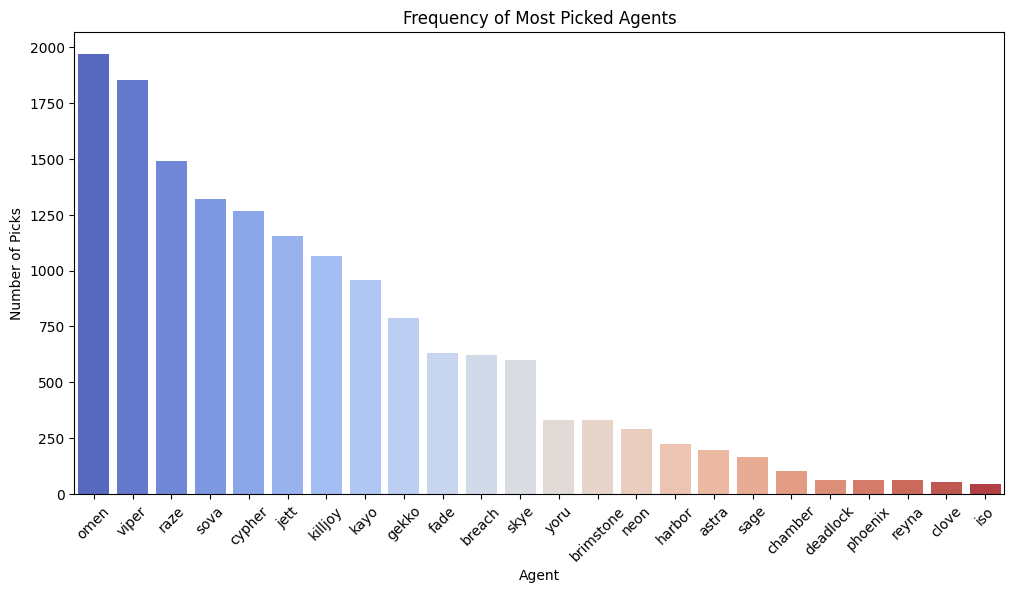

In [15]:
agent_pick_freq = agents_df.sum().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x=agent_pick_freq.index, y=agent_pick_freq.values, palette="coolwarm")
plt.title("Frequency of Most Picked Agents")
plt.xlabel("Agent")
plt.ylabel("Number of Picks")
plt.xticks(rotation=45)
plt.show()

Above is the pick rate of agents. Some agents which have been introduced recently will logically have less no. of picks

------------------

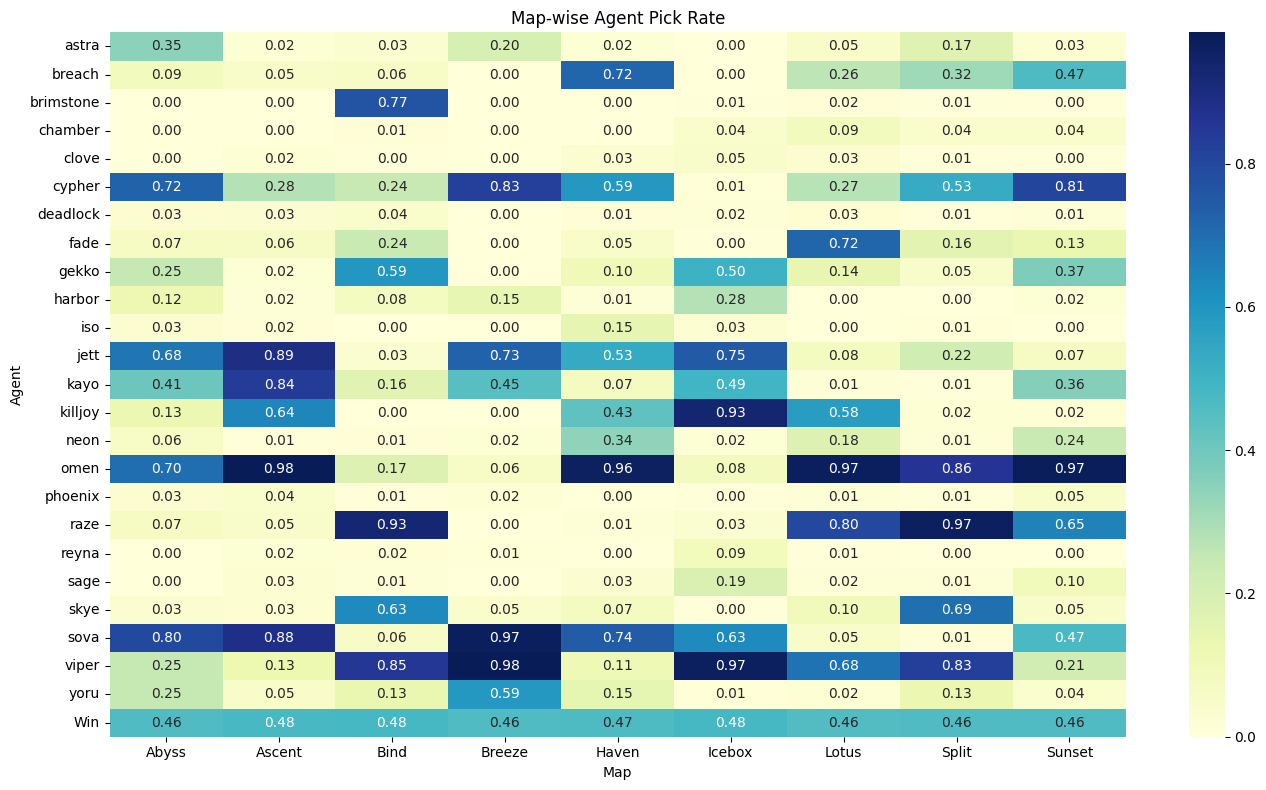

In [16]:
# Create dummy columns
combo_df = agents_df.copy()
combo_df['Map'] = data['Map']
combo_df['Win'] = data['Match Outcome']

# Group by map and agent, compute win rate
heat_data = combo_df.groupby('Map').mean().T 
plt.figure(figsize=(14, 8))
sns.heatmap(heat_data, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Map-wise Agent Pick Rate")
plt.ylabel("Agent")
plt.xlabel("Map")
plt.tight_layout()
plt.show()

Here we try to find map-wise pick rates of agents. We can clearly see that certain agents have high demands for certain maps like raze in split, sova and viper in Breeze and omen in Ascent etc.

In [17]:
roles = {
    'omen': 'controller', 'viper': 'controller', 'brimstone': 'controller',
    'sova': 'initiator', 'kayo': 'initiator', 'breach': 'initiator',
    'skye': 'initiator', 'fade': 'initiator', 'gekk': 'initiator',
    'jett': 'duelist', 'raze': 'duelist', 'yoru': 'duelist',
    'neon': 'duelist', 'iso': 'duelist',
    'killjoy': 'sentinel', 'cypher': 'sentinel', 'sage': 'sentinel',
    'chamber': 'sentinel', 'clove': 'sentinel', 'deadlock': 'sentinel'
}


In [18]:
def role_counts(agent_list):
    count = {'duelist': 0, 'controller': 0, 'initiator': 0, 'sentinel': 0}
    for agent in agent_list:
        role = roles.get(agent, None)
        if role:
            count[role] += 1
    return tuple(count[r] for r in ['duelist', 'controller', 'initiator', 'sentinel'])

data['Role Combo'] = data['Agents Played'].apply(role_counts)


-----------------

In [19]:
from collections import defaultdict
import pandas as pd

map_role_win = defaultdict(lambda: {'wins': 0, 'games': 0})

for _, row in data.iterrows():
    key = (row['Map'], row['Role Combo'])
    map_role_win[key]['games'] += 1
    map_role_win[key]['wins'] += row['Match Outcome']

# Create dataframe
role_map_stats = []
for (map_name, role_combo), stats in map_role_win.items():
    if stats['games'] >= 5: 
        role_map_stats.append({
            'Map': map_name,
            'Role Combo': role_combo,
            'Games': stats['games'],
            'Win Rate': stats['wins'] / stats['games']
        })

df_role_map = pd.DataFrame(role_map_stats)

In [20]:
pivot = df_role_map.pivot(index='Role Combo', columns='Map', values='Win Rate')
pivot = pivot.fillna(0)  

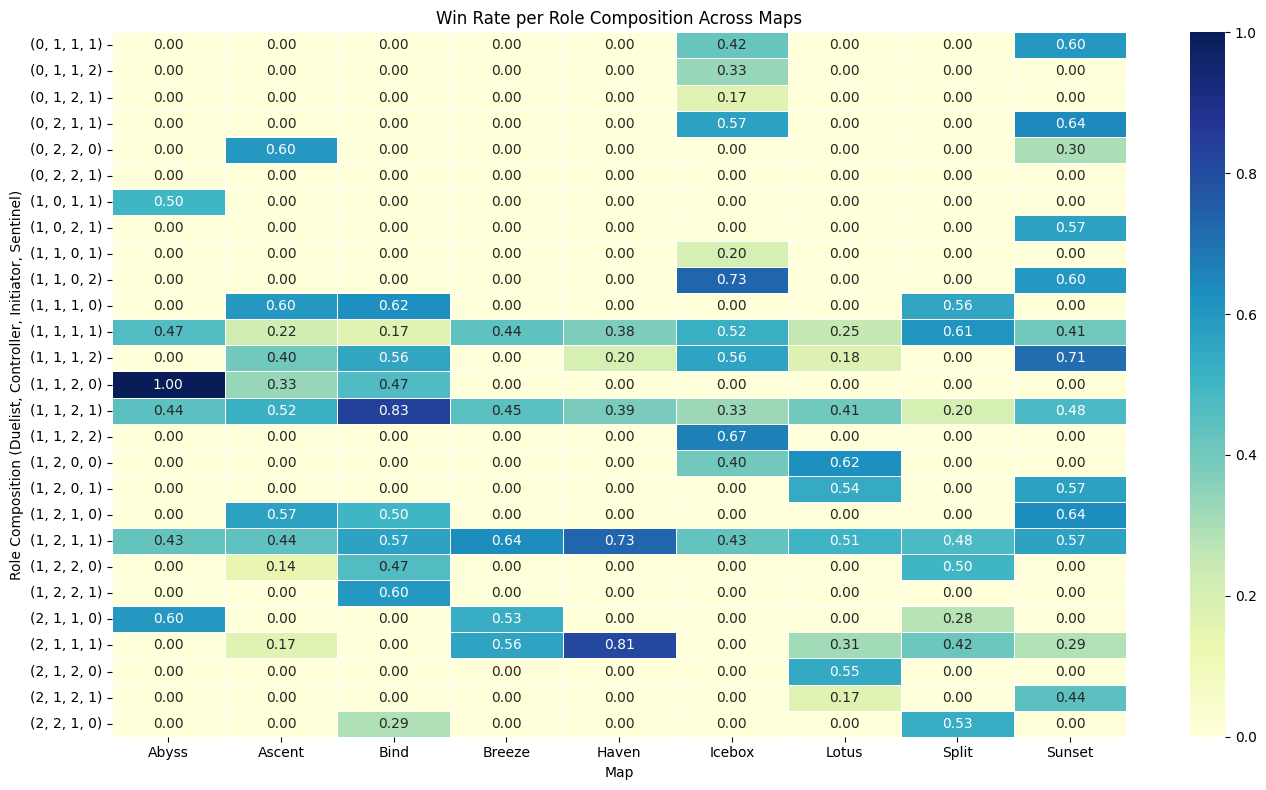

In [21]:
plt.figure(figsize=(14, 8))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap="YlGnBu", linewidths=0.5)
plt.title("Win Rate per Role Composition Across Maps")
plt.ylabel("Role Composition (Duelist, Controller, Initiator, Sentinel)")
plt.xlabel("Map")
plt.tight_layout()
plt.show()


Win Rate per Role Composition Across Maps This heatmap shows the win rates of different role compositions—represented as 4-tuples (Duelist, Controller, Initiator, Sentinel)—across each map. Each team in Valorant consists of 5 players, and each player selects an agent that falls into one of four roles. Because each role has unique responsibilities and tactical value, the overall team synergy depends on how many agents of each role are included. The matrix here captures the effectiveness of various role combinations (like 2 Duelists, 1 Controller, 1 Initiator, 1 Sentinel) across different maps. The intensity of the color represents win rate: darker blue means higher win rate for that composition on a given map. This visualization helps identify which role setups tend to work better on each map, providing strategic insight for agent selection.

From this matrix, we observed clear patterns:
- Maps like Bind and Haven tend to favor compositions with 2 Controllers, likely due to the need for smoke and map control.
- Compositions with balanced roles (e.g., 1 Duelist, 1 Controller, 2 Initiators, 1 Sentinel) perform better overall, showing that flexibility and information gathering are often more effective than raw aggression.
- Some maps like Sunset and Icebox show slightly stronger results for 2-Duelist setups, suggesting those maps reward aggressive engagements and fast site entries.


-----------------------

Below we try to find map-wise pick rates of agents.

In [22]:
X = agents_df
y = data['Match Outcome']

reg_model = LinearRegression()
reg_model.fit(X, y)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def predict_win(map_input, agent_input):
    input_data = pd.DataFrame(0, index=[0], columns=X.columns)

    map_column = f"Map_{map_input}"
    if map_column in input_data.columns:
        input_data[map_column] = 1

    for agent in agent_input:
        if agent in input_data.columns:
            input_data[agent] = 1

    prediction = reg_model.predict(input_data)[0]
    win_percentage = sigmoid(prediction) * 100
    return win_percentage

map_input = "Ascent"
agents_input = "Sova", "Iso", "Killjoy", "Jett", "Cypher"
agents_input = [agent_input.lower() for agent_input in agents_input]
win_percentage = predict_win(map_input, agents_input)

print(f"Win probability for map '{map_input}' with agents {agents_input}: {win_percentage:.2f}%")

Win probability for map 'Ascent' with agents ['sova', 'iso', 'killjoy', 'jett', 'cypher']: 61.17%


Above we used simple Linear Regression model to predict the best compositions for each maps. 

In [23]:
data['Comp'] = data['Agents Played'].apply(lambda x: tuple(sorted(x)))

# Group by Map + Comp → Count matches + average win rate
comp_map_stats = (
    data.groupby(['Map', 'Comp'])['Match Outcome']
    .agg(['count', 'mean'])
    .reset_index()
    .rename(columns={'count': 'Games', 'mean': 'Win Rate'})
)

comp_map_stats = comp_map_stats[comp_map_stats['Games'] >= 5]

# Print top comps per map
for map_name in comp_map_stats['Map'].unique():
    print(f"\nTop 5 Comps on {map_name} (Used ≥ 5 times):")
    top = comp_map_stats[comp_map_stats['Map'] == map_name].sort_values('Win Rate', ascending=False).head(5)
    for _, row in top.iterrows():
        comp_str = ', '.join(row['Comp'])
        print(f"  {comp_str} | Win Rate: {round(row['Win Rate'], 2)} | Games: {int(row['Games'])}")



Top 5 Comps on Abyss (Used ≥ 5 times):
  cypher, harbor, jett, omen, sova | Win Rate: 0.83 | Games: 6
  cypher, fade, omen, viper, yoru | Win Rate: 0.6 | Games: 5
  cypher, jett, kayo, omen, sova | Win Rate: 0.47 | Games: 15
  astra, cypher, gekko, jett, sova | Win Rate: 0.38 | Games: 8
  astra, killjoy, sova, viper, yoru | Win Rate: 0.29 | Games: 7

Top 5 Comps on Ascent (Used ≥ 5 times):
  fade, killjoy, omen, viper, yoru | Win Rate: 0.67 | Games: 6
  breach, kayo, omen, phoenix, viper | Win Rate: 0.6 | Games: 5
  fade, gekko, omen, raze, viper | Win Rate: 0.57 | Games: 7
  jett, kayo, killjoy, omen, sova | Win Rate: 0.55 | Games: 221
  cypher, jett, kayo, omen, sova | Win Rate: 0.43 | Games: 58

Top 5 Comps on Bind (Used ≥ 5 times):
  brimstone, cypher, kayo, raze, sova | Win Rate: 1.0 | Games: 5
  brimstone, cypher, kayo, raze, viper | Win Rate: 0.86 | Games: 7
  brimstone, gekko, omen, raze, skye | Win Rate: 0.8 | Games: 5
  brimstone, jett, raze, skye, viper | Win Rate: 0.6 | Ga

Above we can see the top agent compositions for each maps. This we have found out through historical data and now we will train a ML model to learn the patterns and it will be able to give the win probability for agent compositions

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

import xgboost as xgb

xgb_model = xgb.XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.1, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

print("XGBoost Accuracy:", xgb_model.score(X_test, y_test))

c:\Users\Vedant Hirekar\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [22:22:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Accuracy: 0.5521172638436482


In [25]:
comp_features = []
comp_labels = []

for _, row in comp_map_stats.iterrows():
    comp = row['Comp']
    map_name = row['Map']

    feature = pd.Series(0, index=X.columns)
    for agent in comp:
        if agent in feature:
            feature[agent] = 1

    map_col = f"Map_{map_name}"
    if map_col in feature:
        feature[map_col] = 1

    comp_features.append(feature)
    comp_labels.append((map_name, comp))

X_comps = pd.DataFrame(comp_features)
probs = xgb_model.predict_proba(X_comps)[:, 1]


In [26]:
predicted_comp_scores = pd.DataFrame({
    'Map': [m for m, _ in comp_labels],
    'Comp': [c for _, c in comp_labels],
    'Predicted Win Prob': probs
})

for map_name in predicted_comp_scores['Map'].unique():
    print(f"\nPredicted Top Comps for {map_name}:")
    top = predicted_comp_scores[predicted_comp_scores['Map'] == map_name].sort_values('Predicted Win Prob', ascending=False).head(5)
    for _, row in top.iterrows():
        print(f"  {', '.join(row['Comp'])} | Predicted Win Prob: {round(row['Predicted Win Prob'], 2)}")


Predicted Top Comps for Abyss:
  cypher, harbor, jett, omen, sova | Predicted Win Prob: 0.73
  cypher, fade, omen, viper, yoru | Predicted Win Prob: 0.47
  cypher, jett, kayo, omen, sova | Predicted Win Prob: 0.45
  astra, cypher, gekko, jett, sova | Predicted Win Prob: 0.34
  astra, killjoy, sova, viper, yoru | Predicted Win Prob: 0.14

Predicted Top Comps for Ascent:
  breach, kayo, omen, phoenix, viper | Predicted Win Prob: 0.78
  fade, killjoy, omen, viper, yoru | Predicted Win Prob: 0.58
  jett, kayo, killjoy, omen, sova | Predicted Win Prob: 0.55
  cypher, deadlock, jett, omen, sova | Predicted Win Prob: 0.53
  astra, jett, kayo, omen, sova | Predicted Win Prob: 0.52

Predicted Top Comps for Bind:
  brimstone, cypher, kayo, raze, sova | Predicted Win Prob: 0.94
  brimstone, cypher, kayo, raze, viper | Predicted Win Prob: 0.82
  brimstone, gekko, omen, raze, skye | Predicted Win Prob: 0.75
  gekko, harbor, raze, skye, viper | Predicted Win Prob: 0.63
  brimstone, cypher, raze, sk

Here we can see the predicted top comps given by our model. The win probability seems to be similar to actual probabilities indicating good performance.

In [27]:
def predict_comp_win_prob(comp, map_name, model, feature_columns):
    """
    comp: list of 5 agent names (lowercase, match column names)
    map_name: string, e.g., 'Ascent'
    model: trained sklearn model
    feature_columns: full feature column list used in training (X.columns)
    """
    input_vec = pd.Series(0, index=feature_columns)

    for agent in comp:
        if agent in input_vec:
            input_vec[agent] = 1

    map_col = f"Map_{map_name}"
    if map_col in input_vec:
        input_vec[map_col] = 1

    input_df = pd.DataFrame([input_vec])
    prob = model.predict_proba(input_df)[0][1]
    return round(prob, 3)

In [28]:
my_comp = ['brim', 'jett', 'sova', 'cypher', 'sage']
map_name = 'Ascent'

win_prob = predict_comp_win_prob(my_comp, map_name, xgb_model, X.columns)
print(f"Predicted Win Probability for {my_comp} on {map_name}: {win_prob}")

Predicted Win Probability for ['brim', 'jett', 'sova', 'cypher', 'sage'] on Ascent: 0.3889999985694885


Above we can give in different agent compositions and check their win probability. 